In [1]:
import numpy as np
import math
import ceo
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#def disp(x): print np.array_str(x,precision=1,suppress_small=True)
tid = ceo.StopWatch()

In [3]:
nLenslet = 30
n = 8
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("R",zenith=0*math.pi/180/3600,azimuth=0*math.pi/4,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
imgr = ceo.ShackHartmann(1, nPx-1, D ,DFT_osf=4,N_PX_IMAGE=0.5*(nPx-1))
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n)

In [4]:
gmt = ceo.GMT_MX(D,nPx)

[ 0.7910409]


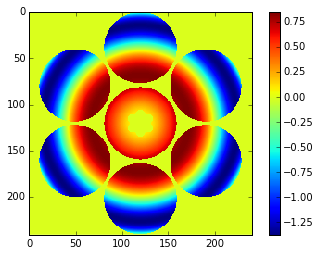

In [5]:
gmt.propagate(src)
imshow(1e9*src.phase.host(),interpolation='None')
colorbar()
wfs.calibrate(src,0.75)
imgr.calibrate(src,0.0)
print src.wavefront.rms()*1e9

In [6]:
src.wavefront.piston()*1e9

-0.19655328753476198

In [7]:
src.wavefront.piston(mask=gmt.M1.piston_mask)*1e9

array([-0.29370382, -0.29432261, -0.29432005, -0.29370227, -0.29432118,
       -0.29432184,  0.45820642], dtype=float32)

In [8]:
def ray_trace(mirror='M1',T=[0,0,0],O=[0,0,0],segId=0):
    
    print "IMAGER pixel scale  : %5.2fmas"%(1e3*imgr.pixel_scale_arcsec)
    print "IMAGER field-of-view: %5.2fmas"%(1e3*imgr.pixel_scale_arcsec*nPx*2)
    print "WFS pixel scale     : %5.2fmas"%(1e3*wfs.pixel_scale_arcsec)
    print "WFS field-of-view   : %5.2fmas"%(1e3*wfs.pixel_scale_arcsec*n*2)
    
    if mirror=="M1":
        gmt.M1.update(origin=T,euler_angles=O,idx=segId)
    if mirror=="M2":
        gmt.M2.update(origin=T,euler_angles=O,idx=segId)
    if mirror=="M2 pointing neutral":
        gmt.M2.pointing_neutral(O[0],O[1])
    if mirror=="M2 coma neutral":
        gmt.M2.coma_neutral(O[0],O[1])
    src.reset()
    
    gmt.propagate(src)

    imgr.reset()
    tid.tic()
    imgr.propagate(src)
    tid.toc()
    
    wfs.reset()
    wfs.analyze(src)
    print np.median(wfs.c.host(units='arcsec'))

   # fig, ((ax1,ax2),(ax3,ax4)) = subplots(nrows=2, ncols=2)
    fig = figure()
    fig.set_size_inches(20,25)
    
    ax1 = subplot2grid( (3,2), (0,0))
    """
    xf = xyzf[:,0]
    yf = xyzf[:,1]
    ax1.plot(xf[P1D>0]*1e6,yf[P1D>0]*1e6,'.')
    ax1.grid()
    ax1.set_aspect(aspect=1)
    ax1.set_xlabel('X [micron]')
    ax1.set_ylabel('Y [micron]')
    ax1.set_title('Spot diagram @ focus')
    """
    
    #opd = np.reshape(rays.optical_path_difference.host()*1e9,(n_radius,n_radius))
    opd = src.phase.host(units='nm')
    ax2 = subplot2grid( (3,2), (0,1))
    hi = ax2.imshow(opd,interpolation='none',origin='lower')
    h = colorbar(hi,ax=ax2)
    h.set_label('OPD [nm]')
    grid()
    ax2.set_title( "WFE [nm]: RMS %4.2f"%(1e9*src.wavefront.rms()) )
#    ax2.set_title( "WFE [nm]: RMS %4.2f & PtV %4.2f"%(np.std(opd[P>0]),(np.max(opd[P>0]) - np.min(opd[P>0]))))
    
    ax3 = subplot2grid( (3,2), (1,0))
    lim = nPx*imgr.pixel_scale_arcsec
    h3 = ax3.imshow((imgr.frame.host()),interpolation='none',extent=[-lim,lim,-lim,lim],origin='lower')
    ax3.grid()
    ax3.set_xlabel('X [arcsec]')
    ax3.set_ylabel('Y [arcsec]')
    psf_c = imgr.c.host(units='arcsec')
    ax3.set_title("[Cx,Cy]=[%4.2f,%4.2f]arcsec"%(psf_c[0,0],psf_c[0,1]))
    colorbar(h3,ax=ax3)
    
    ax4 = subplot2grid( (3,2), (1,1))
    h4 = ax4.imshow((wfs.frame.host()),interpolation='none')
    colorbar(h4,ax=ax4)
    
    ax5 = subplot2grid( (3,2), (2,0),colspan=2)
    h5 = imshow(1e3*wfs.c.host(units='arcsec').reshape(2*nLenslet
                                ,nLenslet).transpose(),interpolation='none')
    hc5 = colorbar(h5,ax=ax5)
    hc5.set_label('centroids [mas]')
    
    fig.tight_layout()

In [11]:
mas2rad = 1e-3*math.pi/180/3600
#M1.reset()
#M2.reset()
#M1.global_tiptilt(0.*math.pi/180/3600.0,1.*math.pi/180.0/3600)
#M1.zernike.reset()
#M2.zernike.reset()
#for k in range(7):
#    M1.zernike.a[k,k] = 1e-7
#M1.zernike.a[2,4] = 0e-7
#M1.zernike.update()
#M2.zernike.a[2,4] = 1e-7
#M2.zernike.update()
#ray_trace(mirror='M2 pointing neutral',T=[0e-3,0e-6,0e-9],O=[x*mas2rad for x in [1000,0,0]],segId=1)
ray_trace(mirror='M1',T=[0e-3,0e-6,0e-9],O=[x*mas2rad for x in [1000,0,0]],segId=0)

IMAGER pixel scale  :  1.29mas
IMAGER field-of-view: 623.81mas
WFS pixel scale     : 77.65mas
WFS field-of-view   : 1242.44mas


AssertionError: The segment index idx must be between 1 and 7!

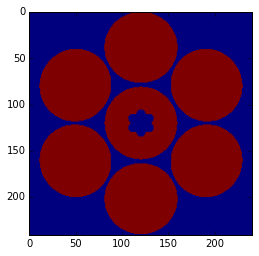

In [10]:
fig = imshow(src.rays.vignetting.host().reshape(nPx,nPx))

<matplotlib.colorbar.Colorbar instance at 0x2b3322f3cc68>

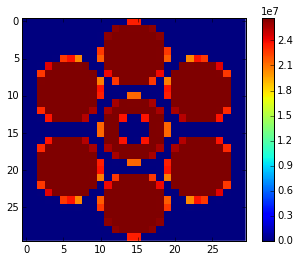

In [11]:
imshow(wfs.flux.host(),interpolation='none')
colorbar()

In [12]:
D = gmt.calibrate(wfs,src,mirror='M2',mode='segment tip-tilt',stroke=50e-3*math.pi/180/3600)

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


In [13]:
D

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.00269784,  0.27128389,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00033806,  0.2702516 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00033732,  0.27025229,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

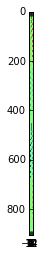

In [14]:
imshow(D)

In [15]:
D.shape

(904, 14)